# Start And End Location Analysis
---
In this section we analyze the time between trips for the Chicago taxi fleet. This target shows the efficency of each company in utilizing their taxi fleet and the typical waiting time for drivers after each trip.

We proceed as following:
- Trying to get an overview of time in between trips (idle time) by looking at the total number of taxis oprating in Chicago in 2015 and idle time statistical distribution
- Looking for extreme values (outliers) and removing them using z-score
- Univariate analysis
- Bivariate anaylysis with different temporal and spatial resolution


_Note: Many visualizations in this notebook are first produced with high dpi and saved as an image and then loaded back to the notebook. This is done to avoid long running times.
Thus the cells containing the logic to produce these plots are commented out. If you want to run these cells:
please make sure that you have enough memory (about 32 GB) and please be patient._

In [1]:
cd ..

/Users/christianbergen/Documents/prog/aaa21


In [2]:
import numpy as np
import utils,geo_engineering,eda,feature_engineering
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import matplotlib.gridspec as gridspec
from PIL import Image as pilim
import seaborn as sns
from scipy.stats import zscore
from haversine import haversine_vector, Unit

#Global visualization setting
plt.rcParams['figure.dpi'] = 400
sns.color_palette("dark")
sns.set_style("ticks")

%matplotlib inline


In [3]:
chicago_df = utils.read_parquet('Taxi_Trips_Cleaned.parquet',
                                columns=['Trip ID','Taxi ID','Trip Start Timestamp',
                                        'Trip End Timestamp','Pickup Community Area',
                                         'Dropoff Community Area','Trip Start Hour','Trip End Hour'])
chicago_df.head()



,Trip ID,Taxi ID,Trip Start Timestamp,Trip End Timestamp,Pickup Community Area,Dropoff Community Area,Trip Start Hour,Trip End Hour
0,70bf5261bff10278c0a99bf9b6dfd77b59da3f7b,d227267f2ecc06b906db9813671d5c14b2ca025df56515...,2015-01-01 00:00:00,2015-01-01 00:00:00,1.0,1.0,0,0
1,8a01052178bc15bd780297e93aaf328dc631ef3c,aafe2cb9e0f06a82f8b995a8292190fed97bc4b41f04d3...,2015-01-01 00:30:00,2015-01-01 00:30:00,8.0,8.0,0,0
2,097e67b0a173656e34f6ea4e8077c802ed55ab9f,4f3bc023d606842442d6275624a11dcf86dc1cbf201c5e...,2015-01-01 00:45:00,2015-01-01 00:45:00,8.0,8.0,0,0
3,35c0c4859532bafa924ee1e50d3b4aae575a63fd,4f3bc023d606842442d6275624a11dcf86dc1cbf201c5e...,2015-01-01 00:45:00,2015-01-01 01:00:00,8.0,6.0,0,1
4,95f482f9494be7695fe051572d7928090f46fcb2,8b12673d17dc4423a80ecc1f53d090cff311496e1694d7...,2015-01-01 00:45:00,2015-01-01 01:00:00,22.0,21.0,0,1


In [4]:
chicago_df  = chicago_df.sample(frac=0.1)
chicago_df.head()

,Trip ID,Taxi ID,Trip Start Timestamp,Trip End Timestamp,Pickup Community Area,Dropoff Community Area,Trip Start Hour,Trip End Hour
2985819,045cf48695b76f4ba35cb1b093bfb069e1bb7f8a,fdb16324f07e66dd7338161569ae6991f89e38884bac4a...,2015-02-19 09:15:00,2015-02-19 09:45:00,32.0,41.0,9,9
2872913,1b10f174d15f15857c8ebb6a0e4f586238207d65,adb1cb74113851b651b474182fbe95a9663783779db8cc...,2015-02-17 15:30:00,2015-02-17 15:45:00,32.0,32.0,15,15
13094408,550a8763c9391e62b1743a4cca557a1f69010047,3c8a3a5b0785d40229dd7adc5fd0d9620defca885601bf...,2015-07-26 02:15:00,2015-07-26 02:15:00,5.0,4.0,2,2
13097443,c79b56e9a2f7669a796dc8f15f714a3ebc16cd29,507b1e4d1f39a8a26e7249e6a627f5a0c798dfdafa7b16...,2015-07-26 02:00:00,2015-07-26 02:15:00,24.0,32.0,2,2
13214811,69c86a27af70aceb76945f9dc21aed211cbfc4e2,adfbb2f2f3f8f81a12f9ad98dd8308669f62baaa8b8f2c...,2015-07-28 15:00:00,2015-07-28 15:00:00,8.0,32.0,15,15


In [5]:
chicago_df = feature_engineering.add_weekday(chicago_df)

In [6]:
feature_engineering.add_time_interval(chicago_df)

In [7]:
chicago_df = geo_engineering.add_community_names(chicago_df)

## Bivariate Analysis
---
In this section we analyze the relationship between start and end locations and different aspects of our data like weekday or hour. This analysis gives us a better understanding of the taxi fleet opration in Chicago.

The analysis is structured as following:

*Temporal Analysis*
- Daily analysis of idle time and weekday
- Six hour analysis showing the relationship between idle time and daily activities
- Hourly analysis

*Spatial Analysis*
- The effect of drop-off location (community areas and h3 hexagons) on idle time
- The macro analysis of the idle time in the city of Chicago using the h3 hexagon (res. 6)

## Top Ten Start And End Locations

In [9]:
top_10_pickup = chicago_df.groupby("Community Area Name_pickup").size().reset_index(name="Total Trips").nlargest(10, "Total Trips")
bottom_10_pickup = chicago_df.groupby("Community Area Name_pickup").size().reset_index(name="Total Trips").nsmallest(10, "Total Trips")

top_10_dropoff = chicago_df.groupby("Community Area Name_dropoff").size().reset_index(name="Total Trips").nlargest(10, "Total Trips")
bottom_10_dropoff = chicago_df.groupby("Community Area Name_dropoff").size().reset_index(name="Total Trips").nsmallest(10, "Total Trips")

In [11]:
bottom_10_pickup

,Community Area Name_pickup,Total Trips
59,RIVERDALE,5
30,HEGEWISCH,8
46,MOUNT GREENWOOD,12
58,PULLMAN,13
20,EAST SIDE,14
12,BURNSIDE,22
73,WEST PULLMAN,24
45,MORGAN PARK,33
9,BEVERLY,39
63,SOUTH DEERING,49


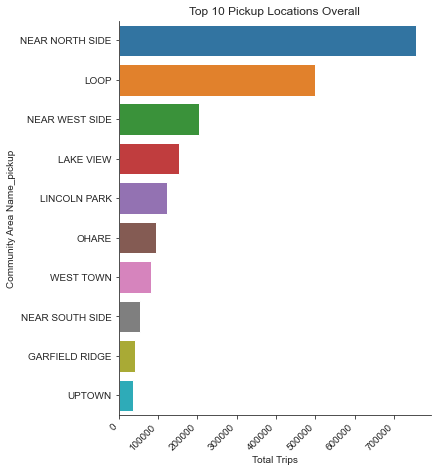

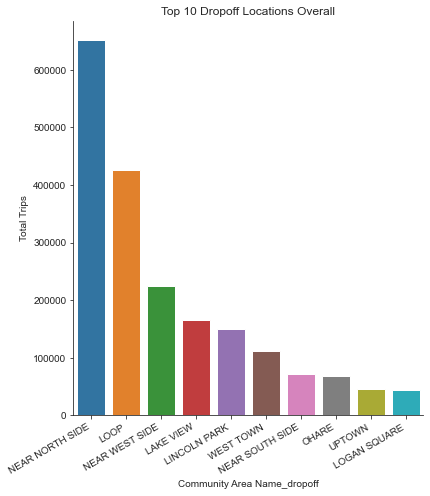

In [22]:
#Pickups
_ = sns.catplot(x="Total Trips", y='Community Area Name_pickup',kind="bar",data=top_10_pickup,height=6,aspect=1)
plt.title('Top 10 Pickup Locations Overall')
plt.xticks(rotation = 45, ha="right") 
_.fig.savefig('img/top_pickup_locations_all.png',bbox_inches='tight')

#Dropoffs
_ = sns.catplot(x="Community Area Name_dropoff",y="Total Trips",kind="bar",data=top_10_dropoff,height=6,aspect=1)
plt.title('Top 10 Dropoff Locations Overall')
plt.xticks(rotation = 30, ha="right") 
_.fig.savefig('img/top_dropoff_locations_all.png',bbox_inches='tight')
plt.show()


77

In [13]:
total_pickup = merged_gdf.groupby(['Pickup Community Area', 'Distance to Center_pickup']).size().reset_index(name="Total Trips")
total_dropoff = merged_gdf.groupby(['Dropoff Community Area', 'Distance to Center_dropoff']).size().reset_index(name="Total Trips")


top_10_pickup = total_pickup.nlargest(12, "Total Trips")
bottom_10_pickup = total_pickup.nsmallest(12, "Total Trips")

top_10_dropoff = total_dropoff.nlargest(12, "Total Trips")
bottom_10_dropoff = total_dropoff.nsmallest(12, "Total Trips")

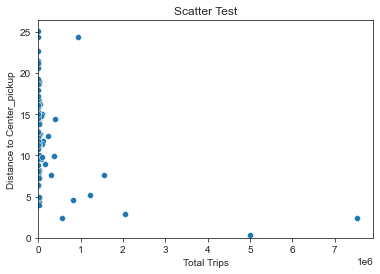

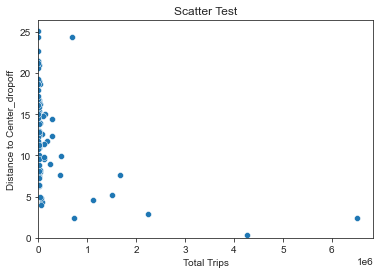

In [17]:
_ = sns.scatterplot(x="Total Trips", y = "Distance to Center_pickup", data=total_pickup)
plt.title('Scatter Test')
plt.xlim(0,)
plt.ylim(0,)
plt.show()

_ = sns.scatterplot(x="Total Trips", y = "Distance to Center_dropoff", data=total_dropoff)
plt.title('Scatter Test')
plt.xlim(0,)
plt.ylim(0,)
plt.show()


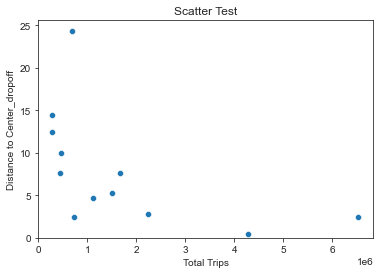

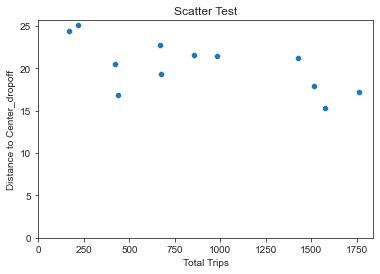

In [18]:
_ = sns.scatterplot(x= "Total Trips", y ="Distance to Center_dropoff", data=top_10_dropoff)
plt.title('Scatter Test')
plt.xlim(0,)
plt.ylim(0,)
plt.show()

_ = sns.scatterplot(x= "Total Trips", y ="Distance to Center_dropoff", data=bottom_10_dropoff)
plt.title('Scatter Test')
plt.xlim(0,)
plt.ylim(0,)
plt.show()